#### Se usará la base de datos datos_credit_balanced_sin_correlación.csv

In [3]:
import pandas as pd

#### Para aumentar la velocidad de lectura del banco de datos, se guardará el csv en formato pkl que es considerablemente más rápido. De ahora en adelante se importará desde ese tipo de archivo

In [4]:
# original_data = pd.read_csv("./data/datos_credit_balanced_sin_correlacion.csv")
# pickeled_data = pd.to_pickle(original_data, "./pickled/datos_credit_balanced_sin_correlacion.pkl")

In [7]:
original_data = pd.read_pickle("./pickled/datos_credit_balanced_sin_correlacion.pkl")

In [8]:
from rich.console import Console
from rich import print
console = Console()

#### Clasificador K-NN

In [11]:
preprocessed_data = pd.read_pickle("./pickled/datos_credit_balanced_sin_correlacion.pkl")
normalized_data = pd.read_pickle("./pickled/datos_credit_balanced_sin_correlacion_normalizado.pkl")

#### Definimos los atributos y la clase objetivo para separar los datos en entrenamiento y prueba

In [13]:
FEATURES_PRE = preprocessed_data.drop('Class', axis=1)
TARGET_PRE = preprocessed_data['Class']
FEATURES_PRE = pd.get_dummies(FEATURES_PRE)

FEATURES_NORM = normalized_data.drop('Class', axis=1)
TARGET_NORM = normalized_data['Class']

In [15]:
from sklearn.model_selection import train_test_split

FEATURES_TRAIN_PRE, FEATURES_TEST_PRE, TARGET_TRAIN_PRE, TARGET_TEST_PRE = train_test_split(FEATURES_PRE, TARGET_PRE, test_size=0.3, random_state=42)
FEATURES_TRAIN_NORM, FEATURES_TEST_NORM, TARGET_TRAIN_NORM, TARGET_TEST_NORM = train_test_split(FEATURES_NORM, TARGET_NORM, test_size=0.3, random_state=42)

#### Sacamos la k óptima

In [19]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

#### Esto tarda una cantidad considerable de tiempo (a mí me tardo 25 minutos para 1). Si no necesitas que use el 100% de la CPU, quita el argumento 'n_jobs' o ponlo a 1 ó 2, sin embargo esto hará que tarde más.

Minimum error:- 0.024638165415120553 at K = 0


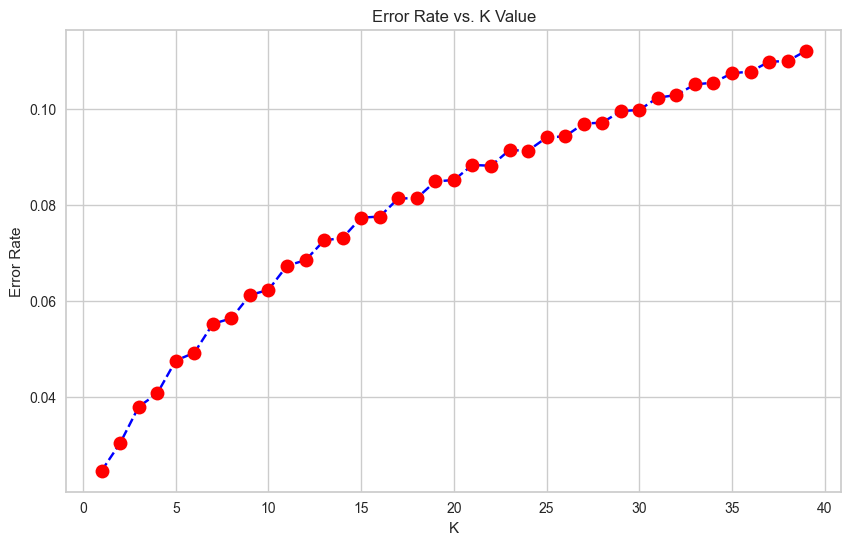

In [20]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(FEATURES_TRAIN_PRE,TARGET_TRAIN_PRE)
    pred_i = knn.predict(FEATURES_TEST_PRE)
    error_rate.append(np.mean(pred_i != TARGET_TEST_PRE))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-", min(error_rate),"at K =", error_rate.index(min(error_rate)))

Maximum accuracy:- 0.9995075884142588 at K = 1


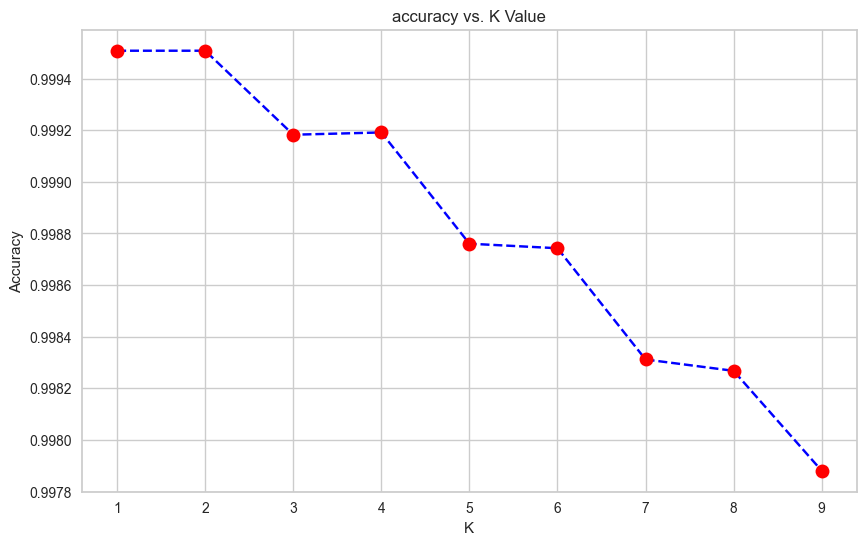

In [30]:
acc = []
from sklearn import metrics
for i in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=i, weights='distance').fit(FEATURES_TRAIN_NORM,TARGET_TRAIN_NORM)
    yhat = neigh.predict(FEATURES_TEST_NORM)
    acc.append(metrics.accuracy_score(TARGET_TEST_NORM, yhat))

plt.figure(figsize=(10,6))
plt.plot(range(1,10),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-", max(acc),"at K =", acc.index(max(acc)) + 1)